# Yelp Data Sentiment Analysis 

#### Perform Sentiment Analysis using SVM

In [104]:
import os.path
import re
import string
import seaborn as sns
import pandas
import matplotlib.pyplot as plt
from pathlib import Path
from pyspark.sql import SparkSession
from boto3.session import Session
from pyspark import SparkContext 
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.functions import udf, expr, concat, col
from pyspark.sql.types import IntegerType
from nltk.corpus import stopwords
from pyspark.ml.feature import *
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import SVMWithSGD
from pyspark.ml import linalg as ml_linalg
from pyspark.mllib.linalg import Vectors as MLLibVectors
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import SVMWithSGD
from numpy import array
from pyspark.mllib.util import MLUtils
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from PIL import Image

%matplotlib inline

### Set up Amazon S3 Credentials (Note:- Our access and secret keys are removed for security purposes)

In [2]:
ACCESS_KEY = 'MYACCESSKEY'
SECRET_KEY = 'MYSECRETKEY'
BUCKET_NAME = 'yelpbigdata'
PREFIX = 'root'
MAX_FILES_READ = 4

In [3]:
session = Session(aws_access_key_id=ACCESS_KEY, aws_secret_access_key=SECRET_KEY)

In [4]:
s3 = session.resource('s3')

In [5]:
my_bucket = s3.Bucket(BUCKET_NAME)
print(my_bucket)

s3.Bucket(name='yelpbigdata')


In [6]:
spark = SparkSession.builder.appName('BDF').getOrCreate()

In [7]:
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", ACCESS_KEY)
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", SECRET_KEY)
spark._jsc.hadoopConfiguration().set("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")
spark._jsc.hadoopConfiguration().set("com.amazonaws.services.s3.enableV4", "true")
spark._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.BasicAWSCredentialsProvider")
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3-eu-west-1.amazonaws.com")

### Check if the file exists and the bucket is initialised correctly

In [8]:
index = 0
for s3_file in my_bucket.objects.filter(Prefix=""):
    print(s3_file)
    if 'csv' in s3_file.key:
        print("YO")
        index += 1
        print ("Found file: {file}".format(file=s3_file.key))
        if index == MAX_FILES_READ:
            break
        fileLocation = "s3a://{bucket}/{file}".format(bucket=BUCKET_NAME,file=s3_file.key)
        print ("file location: {loc}".format(loc=fileLocation))
        s3File = sc.textFile(fileLocation)
print(s3File)

s3.ObjectSummary(bucket_name='yelpbigdata', key='yelp_review.csv')
YO
Found file: yelp_review.csv
file location: s3a://yelpbigdata/yelp_review.csv
s3a://yelpbigdata/yelp_review.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0


### Download the Data from the S3 Bucket and load into the dataframe

In [9]:
my_bucket.download_file('yelp_review.csv',"review.csv")

In [10]:
df_review = spark.read.format("com.databricks.spark.csv").option("wholeFile", "true").option("multiline","true").option("header", "true").option("inferSchema", "true").option("delimiter", ",").option("encoding", "ISO-8859-1").option("charset", "ISO-8859-1").option("quote", "\"").option("escape", "\"").load("/content/review.csv")

In [11]:
df_review=df_review.drop('_c0')

### Verify if the dataframe is loaded properly

In [14]:
df_review.select('review_id').distinct().show()

+--------------------+
|           review_id|
+--------------------+
|eSmuw_7aCamAWhKdi...|
|4ueKWKLBGUdqlBAHL...|
|N-47CYWYryHK3T08d...|
|q5yeoNA71ztDxL9os...|
|TLDkttZB7QqraRebe...|
|fdnYkWFGL7c4EI_fD...|
|CwVPsBftuOfeCsD_n...|
|UfsfK7N5s3C9yYfq-...|
|wAQjcUIaH3YZifok0...|
|VUTPmJf5l40RKJr5X...|
|PAkOX8JE6QZ_imz9N...|
|UGPLubG5lvsTEeDEs...|
|jsIu0mzYr4TrugEZz...|
|AYoeCStffV79rgI7x...|
|MAQjxKeR7oDFOmoeT...|
|-1qxlXvAu8YOefjzj...|
|t4ryBLTEnAZWq0rYH...|
|GH05Igv_MMFyDfSqV...|
|UitkfAeTPJHKolK6o...|
|dUWfWiDg0u-giUFME...|
+--------------------+
only showing top 20 rows



In [15]:
df_review.select('review_id').distinct().count()

1000000

In [24]:
df_review = df_review.filter(df_review.stars.isNotNull())

+-----+------+
|stars| count|
+-----+------+
|    1|156690|
|    2| 78883|
|    3|104973|
|    4|210363|
|    5|449091|
+-----+------+



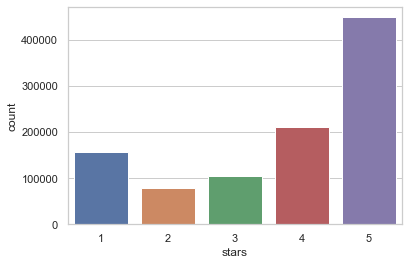

In [29]:
df_star = df_review.groupBy('stars').agg(count('review_id').alias('count')).sort('stars')
df_star.show()
df_star = df_star.withColumn('stars', col('stars').cast('int'))
df_star = df_star.withColumn('count', col('count').cast('int'))
pd_star = df_star.toPandas()
sns.set(style="whitegrid")
sns.barplot(x = "stars", y = "count", data = pd_star)

### We can observe that the main cluster of the reviews are on the positive areas, Meaning people tend to leave reviews when they get a good experience. Also it can be observed that the number of bad or (extreme) negative reviews (1 star)are much more than two or three star (neutral reviews) also showing a correlation between when people post reviews based on their experience

### Data cleaning pre-processing

#### Change the labels of all the reviews having >3 stars to be 1 i.e Positive and everything else to be 0 i.e negative and then do the text processing

In [32]:
# Strip texts
def punct_rem(text):
    reg = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    st = reg.sub(" ", str(text))
    return(st)

# Relabel the stars
def rel_star(star):
    star = int(star)
    if star >=4: return(1)
    else: return(0)
    
starF = udf(lambda x: rel_star(x))
pctF = udf(lambda x: punct_rem(x))

In [36]:
fin_df = df_review.select('review_id', pctF('text'), starF('stars'))

fin_df = fin_df.withColumnRenamed('<lambda>(text)', 'text').withColumn('label', fin_df["<lambda>(stars)"].cast(IntegerType())).drop('<lambda>(stars)')

#### Create Tokens and Remove stopwords to avoid unnecessary computations

In [39]:
#Create Tokens

token = Tokenizer(inputCol="text", outputCol="words")
find_df_token = token.transform(fin_df)

#Remove stop words to save space and avoid unnecessary computations

stp_rem = StopWordsRemover(inputCol='words', outputCol='clean_text')
find_df_token = stp_rem.transform(find_df_token)

In [40]:
find_df_token.select('text', 'clean_text', 'label').show()

+--------------------+--------------------+-----+
|                text|          clean_text|label|
+--------------------+--------------------+-----+
|As someone who ha...|[someone, worked,...|    0|
|I am actually hor...|[actually, horrif...|    0|
|I love Deagan s  ...|[love, deagan, , ...|    1|
|Dismal  lukewarm ...|[dismal, , lukewa...|    0|
|Oh happy day  fin...|[oh, happy, day, ...|    1|
|This is definitel...|[definitely, favo...|    1|
|Really good place...|[really, good, pl...|    1|
|Awesome office an...|[awesome, office,...|    1|
|Most delicious au...|[delicious, authe...|    1|
|I have been here ...|[twice, , nice, l...|    1|
|Maria is VERY goo...|[maria, good, gre...|    1|
|ORDER In  Deliver...|[order, , deliver...|    1|
|We purchased new ...|[purchased, new, ...|    1|
|Everything that m...|[everything, husb...|    1|
|Called for a     ...|[called, , , , , ...|    1|
|If I could give l...|[give, less, one,...|    0|
|  pm on a super b...|[, , pm, super, b...|    0|


#### Trigrams

In [41]:
n = 3
three_gram = NGram(inputCol = 'words', outputCol = 'trigram', n = n)
tri_ngram = three_gram.transform(find_df_token)

# Find the most occuring ngram from the rdd

tgrams = tri_ngram.rdd.flatMap(lambda x: x[-1]).filter(lambda x: len(x.split())==n)
tgram_freq = tgrams.map(lambda x: (x, 1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False).filter(lambda x: x[1]>=10)
lis_tgram = tgram_freq.map(lambda x: x[0]).collect()

In [44]:
def replace_word(text):
    l_text = text.lower()
    for tgram in lis_tgram:
        return(l_text.replace(tgram, tgram.replace(' ', '_')))
               
df_tgram = udf(lambda x: replace_word(x))
df_tgram = find_df_token.select(df_tgram('text'), 'label').withColumnRenamed('<lambda>(text)', 'text')

In [45]:
# Again create tokens and remove stop words via tgrams

token = Tokenizer(inputCol="text", outputCol="words")
find_df_token = token.transform(fin_df)
tgram_token = token.transform(df_tgram)
tgram_token = stp_rem.transform(tgram_token)

stp_rem = StopWordsRemover(inputCol='words', outputCol='clean_text')
find_df_token = stp_rem.transform(find_df_token)

In [46]:
# Init CountVectorizer
cVect = CountVectorizer(inputCol='clean_text', outputCol='tf')
cVectMod = cVect.fit(find_df_token)
c_Vector = cVectMod.transform(find_df_token)

In [47]:
# TF-IDF
idf_tgram = IDF().setInputCol('tf').setOutputCol('tf-idf_tgram')
tfidf_Mod = idf_tgram.fit(c_Vector)
df_tfidf = tfidf_Mod.transform(c_Vector)

#### SVM Training and Testing

In [52]:
# Split the data (80% Train and 20% Test)

split_data = df_tfidf.select(['tf-idf_tgram', 'label']).randomSplit([0.8,0.2])
test_data = split_data[1].cache()
train_data = split_data[0].cache()

In [53]:
def ml_check(m):
    if isinstance(m, ml_linalg.SparseVector): return MLLibVectors.sparse(m.size, m.indices, m.values)
    elif isinstance(m, ml_linalg.DenseVector): return MLLibVectors.dense(m.toArray())
    else: raise TypeError("Error: {0}".format(type(m)))

In [55]:
rdd_train = train_data.rdd.map(lambda row: LabeledPoint(row[1], ml_check(row[0])))
rdd_test = test_data.rdd.map(lambda row: LabeledPoint(row[1], ml_check(row[0])))

#### Train SVM Model

In [57]:
iterations = 125
regParam = 0.4
svm_mod = SVMWithSGD.train(rdd_train, iterations, regParam=regParam)

In [58]:
# Predict the labels
label_predict = rdd_test.map(lambda x: (float(svm_mod.predict(x.features)), x.label))
df_label_predict = spark.createDataFrame(label_predict, ["prediction", "label"])

In [59]:
df_label_predict.show()

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  1.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  0.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  0.0|
+----------+-----+
only showing top 20 rows



In [62]:
# Check the F1 Score for the SVM Model
f1_check = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_val = f1_check.evaluate(df_label_predict)
print("F1 : %.4f" % ((f1_val)*100))

F1 : 88.6328


### Extract the most positive and negative words in the reviews

In [80]:
vocab_tgram = cVectMod.vocabulary
weights_tgram = svm_mod.weights.toArray().tolist()
df_pos_neg = sqlContext.createDataFrame(zip(vocab_tgram, weights_tgram), schema=['tgram', 'val'])

In [81]:
df_pos_neg.orderBy('val').show()
df_pos_neg.orderBy('val', ascending = False).show()

+-------------+--------------------+
|        tgram|                 val|
+-------------+--------------------+
|        worst|-0.09324354970599408|
|           ok|-0.09304118739764342|
|         rude|-0.07975756195189866|
|     horrible| -0.0761373068611471|
|     terrible|-0.07474949182533894|
|          bad|-0.07212828045209789|
|      nothing|-0.06770278898458112|
|        bland|-0.06527421040031611|
|         okay| -0.0599232717575996|
|     mediocre|-0.05647577383159...|
|         told|-0.05592596871806896|
|      average|-0.05588733819270...|
|disappointing|-0.05553301560918...|
|         poor|-0.05335692040036...|
|         wasn|-0.05176143507845885|
|        money|-0.05105471601615727|
|      however|-0.04899242969661168|
|         said|-0.04884308997229729|
|         slow|-0.04874232641721...|
|   overpriced|-0.04785312228233071|
+-------------+--------------------+
only showing top 20 rows

+----------+-------------------+
|     tgram|                val|
+----------+--------

In [172]:
sortdfneg = df_pos_neg.orderBy('val')
sortdfneg = sortdfneg.rdd.map(lambda x: x.tgram).collect()
sortdfpos = df_pos_neg.orderBy('val', ascending = False)
sortdfpos = sortdfpos.rdd.map(lambda x: x.tgram).collect()

### Positive Words

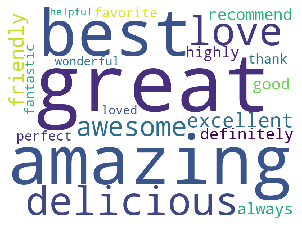

In [183]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 600, background_color ='white',stopwords = stopwords, min_font_size = 7).generate((" ".join(sortdfpos[:20]))) 

plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Negative Words

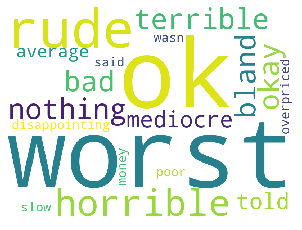

In [186]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 600, background_color ='white',stopwords = stopwords, min_font_size = 7).generate((" ".join(sortdfneg[:20]))) 

plt.figure(figsize = (4, 4), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()